# Project Title

**Authors:** Brandon Sienkiewicz, Ilan Haskel, Zach Cherna


## Overview

## Business Problem

## Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

conn = sqlite3.connect('zippedData/im.db')
%matplotlib inline

In [2]:
df1 = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
df2 = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep = "\t")
df3 = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep = "\t", encoding = 'latin1')
df4 = pd.read_csv('zippedData/tmdb.movies.csv.gz')
df5 = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df6 = pd.read_sql("""
SELECT *
FROM movie_basics b
JOIN movie_ratings r
ON b.movie_id = r.movie_id
""", conn)

tn_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
imbd_df = pd.read_sql("""
SELECT *
FROM movie_basics b
JOIN movie_ratings r
ON b.movie_id = r.movie_id
""", conn)

In [3]:
tnu_df = tn_df.copy()
imbdu_df = imbd_df.copy()
    #creating new dataframes to find matching movies in both dataframes
tnu_df['year'] = pd.DatetimeIndex(tnu_df['release_date']).year
    #converting the release date into year format
tnu_df = tnu_df.drop(columns = ['id','release_date'])
imbdu_df = imbdu_df.drop(columns = ['movie_id',
                                    'original_title',
                                    'movie_id',
                                    'genres'])
    #cleaning the dataframes to only have necessary columns
tnu_df['unique'] = \
tnu_df['movie'].str.cat(tnu_df['year'].astype(str), sep = ' ')
imbdu_df['unique'] = \
imbdu_df['primary_title'].str.cat(imbdu_df['start_year'].astype(str), sep = ' ')
    #creating a new column in each df called unique which combines the
    #movie and the year. this is the first step in removing duplicate movies
tnu_df = tnu_df[tnu_df['unique'].isin(list(imbdu_df['unique']))]
imbdu_df = imbdu_df[imbdu_df['unique'].isin(tnu_df['unique'])]
    #checking the dfs against eachother and ending with  only the movies that
    #are within both dfs
imbdu_df = imbdu_df.sort_values(by='numvotes', ascending=False)
imbdu_df = imbdu_df.drop_duplicates(subset='unique')
    #sorting by number of votes and dropping duplicates. given that tnu_df 
    #represents a smaller data set, it is very likely that the matching
    #movies from the imbdu data set would be the most popular
imbdu_df = imbdu_df.drop(columns=['start_year', 'primary_title'])
tnu_df = tnu_df.drop(columns = ['movie', 'year'])
    #more data cleaning to prepare for a cleaned, merged table
cols = ['unique', 'production_budget',
        'domestic_gross', 'worldwide_gross']
     #rearranging the columns so that the unique film is first
tnu_df = tnu_df[cols]
df_analysis = pd.merge(tnu_df,imbdu_df)
    #merging the two tables into one
cols = ['unique', 'production_budget',
        'domestic_gross', 'worldwide_gross',
        'runtime_minutes', 'averagerating', 'numvotes']
df_analysis = df_analysis[cols]
    #rearranging the columns so that the unique film is first
df_analysis

,unique,production_budget,domestic_gross,worldwide_gross,runtime_minutes,averagerating,numvotes
0,Pirates of the Caribbean: On Stranger Tides 2011,"$410,600,000","$241,063,875","$1,045,663,875",136.0,6.6,447624
1,Dark Phoenix 2019,"$350,000,000","$42,762,350","$149,762,350",113.0,6.0,24451
2,Avengers: Age of Ultron 2015,"$330,600,000","$459,005,868","$1,403,013,963",141.0,7.3,665594
3,Avengers: Infinity War 2018,"$300,000,000","$678,815,482","$2,048,134,200",149.0,8.5,670926
4,Justice League 2017,"$300,000,000","$229,024,295","$655,945,209",120.0,6.5,329135
...,...,...,...,...,...,...,...
1457,Emily 2017,"$27,000","$3,547","$3,547",83.0,6.8,13
1458,Exeter 2015,"$25,000",$0,"$489,792",91.0,4.5,5156
1459,Dutch Kills 2015,"$25,000",$0,$0,90.0,5.1,82
1460,The Ridges 2011,"$17,300",$0,$0,89.0,2.9,127


In [4]:
df_analysis['production_budget'] = \
df_analysis['production_budget'].replace('[\$,]',
                                    '', regex=True).astype(float)
df_analysis['worldwide_gross'] = \
df_analysis['worldwide_gross'].replace('[\$,]',
                                  '', regex=True).astype(float)
df_analysis['domestic_gross'] = \
df_analysis['domestic_gross'].replace('[\$,]',
                                 '', regex=True).astype(float)
    #replacing the $ and , with empty space and converting to float
    #for calculation of correlation and plotting

In [5]:
tnb_df = tn_df.copy()
tnb_df['production_budget'] = \
tnb_df['production_budget'].replace('[\$,]',
                                    '', regex=True).astype(float)
tnb_df['worldwide_gross'] = \
tnb_df['worldwide_gross'].replace('[\$,]',
                                  '', regex=True).astype(float)
tnb_df['domestic_gross'] = \
tnb_df['domestic_gross'].replace('[\$,]',
                                 '', regex=True).astype(float)
    #replacing the $ and , with empty space and converting to float
    #for calculation of correlation and plotting

In [6]:
df_analysis.corr()

,production_budget,domestic_gross,worldwide_gross,runtime_minutes,averagerating,numvotes
production_budget,1.000000,0.711554,0.785485,0.375025,0.226273,0.549558
domestic_gross,0.711554,1.000000,0.945085,0.318571,0.328727,0.668699
worldwide_gross,0.785485,0.945085,1.000000,0.329017,0.310343,0.656622
runtime_minutes,0.375025,0.318571,0.329017,1.000000,0.408142,0.428105
averagerating,0.226273,0.328727,0.310343,0.408142,1.000000,0.499399
numvotes,0.549558,0.668699,0.656622,0.428105,0.499399,1.000000


In [7]:
tnb_df.corr()

,id,production_budget,domestic_gross,worldwide_gross
id,1.000000,-0.035278,0.008255,-0.009422
production_budget,-0.035278,1.000000,0.685682,0.748306
domestic_gross,0.008255,0.685682,1.000000,0.938853
worldwide_gross,-0.009422,0.748306,0.938853,1.000000


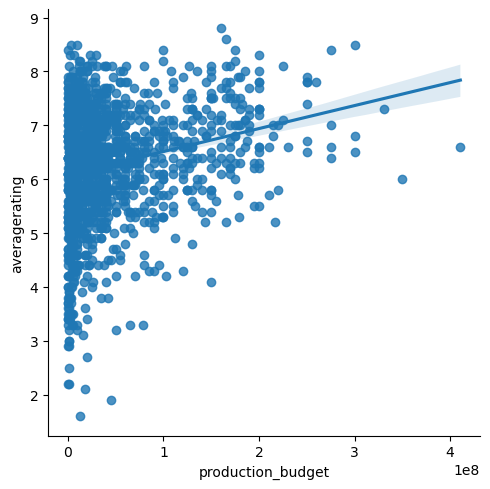

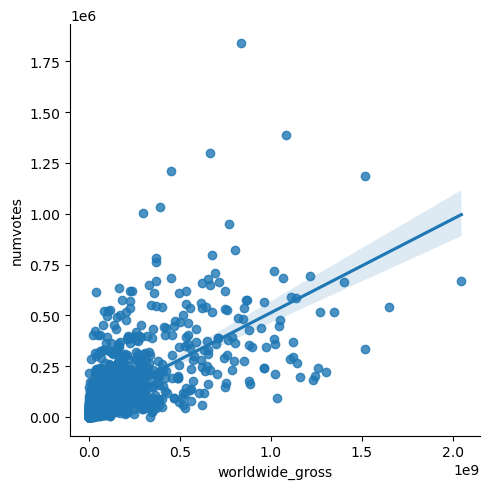

In [8]:
sns.lmplot(x='production_budget', y='averagerating', data=df_analysis)
sns.lmplot(x='worldwide_gross', y='numvotes', data=df_analysis);

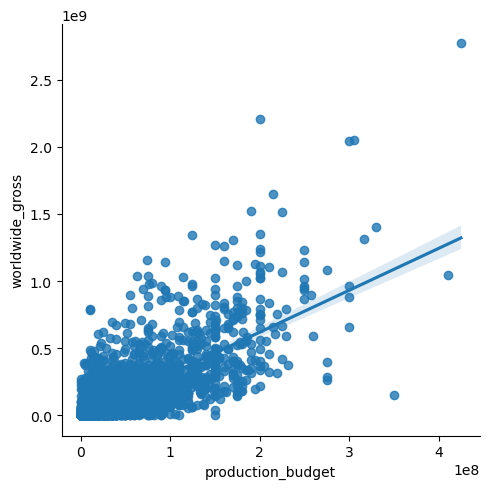

In [9]:
sns.lmplot(x='production_budget', y='worldwide_gross', data=tnb_df);

In [10]:
imdbdf_groupby_runtime = pd.read_sql("""
SELECT b.runtime_minutes, AVG(r.averagerating)
FROM movie_basics b
JOIN movie_ratings r
ON b.movie_id = r.movie_id
GROUP BY b.runtime_minutes
ORDER BY AVG(r.averagerating) DESC
""", conn)
imdbdf_groupby_runtime.isna().sum()

runtime_minutes         1
AVG(r.averagerating)    0
dtype: int64

In [11]:
df6 = df6.rename(columns={'primary_title' : 'movie'})

In [12]:
df6['movie'].value_counts()[:100]

The Return           11
Broken               10
Together              9
Lucky                 9
Homecoming            9
                     ..
Nocturne              4
Jackpot               4
Bodyguard             4
Twelfth Night         4
A Christmas Carol     4
Name: movie, Length: 100, dtype: int64

In [13]:
df5['unique'] = df5['movie'].str.cat(df5['year'].astype(str), sep = ' ')
df6['unique'] = df6['movie'].str.cat(df6['start_year'].astype(str), sep = ' ')
df5

KeyError: 'year'

In [14]:
df5 = df5[df5['unique'].isin(list(df6['unique']))]
df6 = df6[df6['unique'].isin(df5['unique'])]
df6['unique'].value_counts()
df6=df6.sort_values(by='numvotes', ascending=False)
df6 = df6.drop_duplicates(subset='unique')

KeyError: 'unique'

In [15]:
df_new = pd.merge(df5,df6)
df_new.corr()

,id,start_year,runtime_minutes,averagerating,numvotes
id,1.000000,0.017262,-0.037219,0.010373,-0.005445
start_year,0.017262,1.000000,0.065830,0.053334,-0.088208
runtime_minutes,-0.037219,0.065830,1.000000,0.211844,0.363359
averagerating,0.010373,0.053334,0.211844,1.000000,0.311527
numvotes,-0.005445,-0.088208,0.363359,0.311527,1.000000


ValueError: could not convert string to float: '$425,000,000'

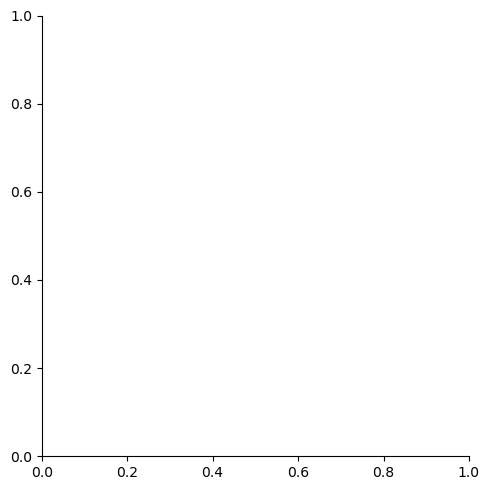

In [16]:
sns.lmplot(x='production_budget', y='averagerating', data=df_new);

In [17]:
df5['production_budget']=df5['production_budget'].replace('[\$,]', '', regex=True).astype(float)
df5['worldwide_gross']=df5['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)
df5['domestic_gross']=df5['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)


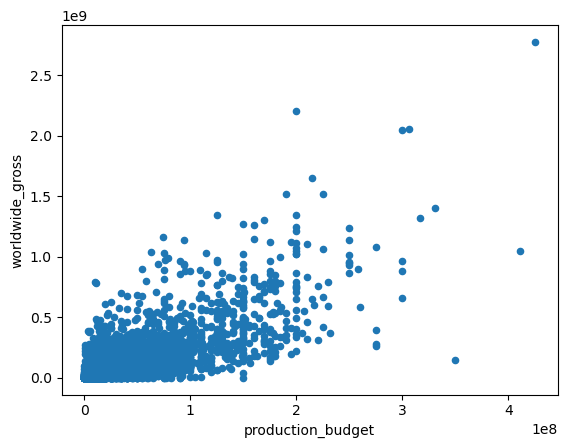

In [18]:
df5.plot('production_budget', 'worldwide_gross', kind='scatter');

In [19]:
df5.corr()

,id,production_budget,domestic_gross,worldwide_gross
id,1.000000,-0.035278,0.008255,-0.009422
production_budget,-0.035278,1.000000,0.685682,0.748306
domestic_gross,0.008255,0.685682,1.000000,0.938853
worldwide_gross,-0.009422,0.748306,0.938853,1.000000


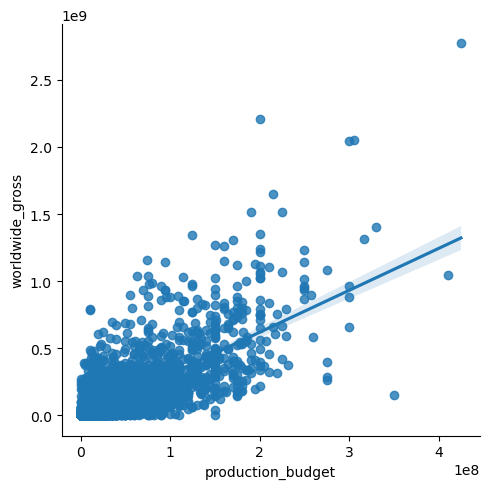

In [20]:
sns.lmplot(x='production_budget', y='worldwide_gross', data=df5);

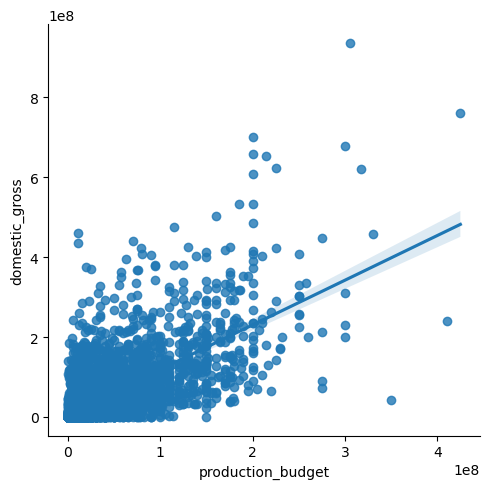

In [21]:
sns.lmplot(x='production_budget', y='domestic_gross', data=df5);

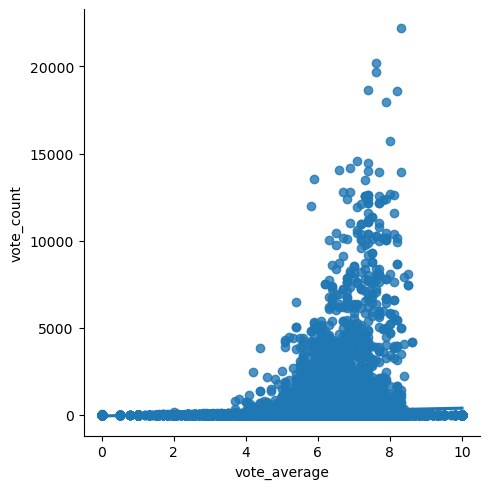

In [22]:
sns.lmplot(x='vote_average', y='vote_count', data=df4);

In [ ]:
df1['studio'].value_counts()